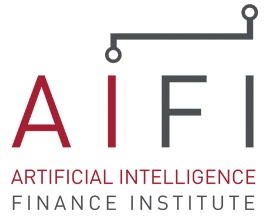


# Bootcamp - Python and Coding - Deep Learning

# About this notebook

This notebook provides an example how to use lerning rate schedulers and learning rate decay with `TensorFlow`. Also, this notebook is to showcase how important it is to not only evaluate the performance of a model, but also the training times and the needed ressources. Considerations:

- __Accuracy vs. Efficiency:__ You should strive for a good balance between prediction accuracy and training efficiency.

- __Model Complexity and Dataset Characteristics:__ The optimal model choice can vary significantly based on the specific characteristics of the dataset, the complexity of the underlying patterns, and the forecasting horizon.


[LR-Scheduler Docu TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler), [LR-Scheduler Docu PyTorch](https://pytorch.org/docs/stable/optim.html)

In [1]:
!pip install keras-self-attention -q

In [2]:
# Standard imports
import pandas as pd
import numpy as np

# Data
import yfinance as yf

# Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, SimpleRNN, Layer, Flatten
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from keras_self_attention import SeqSelfAttention
import tensorflow.keras as keras
from tensorflow.keras.experimental import CosineDecay


# Meassure time
import time

# Metrics
from sklearn.metrics import mean_squared_error

# Plotting
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# to make this notebook's output stable across runs
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


# Parameter

In [4]:
window_size = 10  # Example window size
n_features = 1  # Only using 'Close' as a feature

callback = EarlyStopping(monitor='loss', patience=10)
max_epochs = 1000
batch_size = 32

# Define the ticker symbol
ticker = 'AAPL'



In [5]:

# Fetch data from 2009-08-01 to 2023-12-31
data = yf.download(ticker, start="2009-08-01", end="2023-12-31")

# Preprocess the data
data.index = pd.to_datetime(data.index)

# Define the split date
split_date = pd.Timestamp("2019-08-10")

# Split the data into training and testing based on 'Date'
train_data = data[data.index <= split_date]
test_data = data[data.index > split_date]

# Calculate mean and std only from train_data
mean_close = train_data['Close'].mean()
std_close = train_data['Close'].std()

# Normalize train and test data
train_data['Close'] = (train_data['Close'] - mean_close) / std_close
test_data['Close'] = (test_data['Close'] - mean_close) / std_close

# Prepare lagged features for the LSTM model

# Helper function to create a dataset with lagged features
def create_dataset(dataset, window_size=1):
    X, Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        X.append(a)
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

# Prepare train and test datasets for the models
X_train, y_train = create_dataset(train_data['Close'].values.reshape(-1,1), window_size)
X_test, y_test = create_dataset(test_data['Close'].values.reshape(-1,1), window_size)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))


[*********************100%%**********************]  1 of 1 completed
<ipython-input-5-568602b83d7d>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close'] = (train_data['Close'] - mean_close) / std_close
<ipython-input-5-568602b83d7d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Close'] = (test_data['Close'] - mean_close) / std_close


# LSTM Model

## Learning Rate scheduler

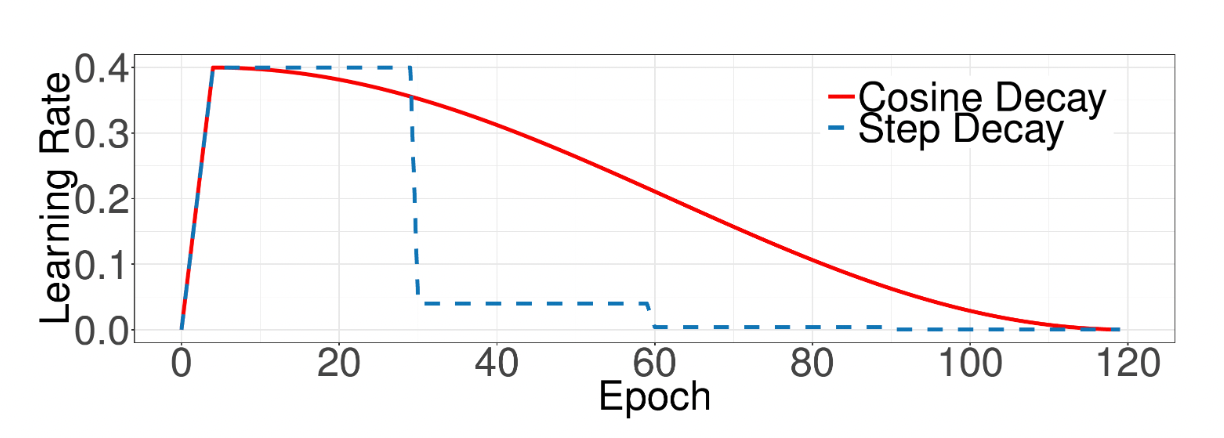

In [6]:
initial_learning_rate = 0.00001
decay_steps = int(max_epochs * len(X_train) / batch_size)

lr_schedule = CosineDecay(initial_learning_rate, decay_steps)


In [7]:
model_LSTM = Sequential()

# Define the optimizer with gradient clipping and LR scheduler
optimizer = Adam(learning_rate=lr_schedule, clipvalue=1.0)

model_LSTM.add(LSTM(4,
                        input_shape=(X_train.shape[1], X_train.shape[2]),
                        activation='linear', return_sequences=False, dropout=0.2,
                        kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))

model_LSTM.add(Dense(1, activation='linear'))
model_LSTM.compile(loss='mse', optimizer=optimizer)

start_time_lstm = time.time()
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, verbose=2, callbacks=[callback])
end_time_lstm = time.time()
time_lstm = end_time_lstm - start_time_lstm

Epoch 1/1000
79/79 - 9s - loss: 0.5012 - 9s/epoch - 112ms/step
Epoch 2/1000
79/79 - 2s - loss: 0.4998 - 2s/epoch - 24ms/step
Epoch 3/1000
79/79 - 2s - loss: 0.4929 - 2s/epoch - 24ms/step
Epoch 4/1000
79/79 - 2s - loss: 0.4798 - 2s/epoch - 25ms/step
Epoch 5/1000
79/79 - 1s - loss: 0.4821 - 996ms/epoch - 13ms/step
Epoch 6/1000
79/79 - 2s - loss: 0.4743 - 2s/epoch - 21ms/step
Epoch 7/1000
79/79 - 1s - loss: 0.4725 - 1s/epoch - 16ms/step
Epoch 8/1000
79/79 - 1s - loss: 0.4621 - 991ms/epoch - 13ms/step
Epoch 9/1000
79/79 - 1s - loss: 0.4524 - 948ms/epoch - 12ms/step
Epoch 10/1000
79/79 - 1s - loss: 0.4458 - 929ms/epoch - 12ms/step
Epoch 11/1000
79/79 - 1s - loss: 0.4495 - 916ms/epoch - 12ms/step
Epoch 12/1000
79/79 - 1s - loss: 0.4415 - 972ms/epoch - 12ms/step
Epoch 13/1000
79/79 - 1s - loss: 0.4343 - 953ms/epoch - 12ms/step
Epoch 14/1000
79/79 - 1s - loss: 0.4270 - 944ms/epoch - 12ms/step
Epoch 15/1000
79/79 - 1s - loss: 0.4254 - 923ms/epoch - 12ms/step
Epoch 16/1000
79/79 - 1s - loss: 0.4

# Stack the Self Attention Layer on Top of LSTM

In [8]:
# Set up the model architecture
model_LA = Sequential()

# Define the optimizer with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)

# LSTM layer with L2 regularization
model_LA.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2]),
                     activation='linear', return_sequences=True, dropout=0.2,
                     kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))

# Self-Attention layer
model_LA.add(SeqSelfAttention(units=4, attention_activation='sigmoid',
                                 attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL))

# Flatten the output to feed into a Dense layer
model_LA.add(Flatten())

# Dense output layer
model_LA.add(Dense(1, activation='linear'))

# Compile the model with the Adam optimizer that includes gradient clipping
model_LA.compile(loss='mse', optimizer=optimizer)

start_time_lstm_attn = time.time()
# Train the model
history = model_LA.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, verbose=2, callbacks=[callback])
end_time_lstm_attn = time.time()
time_lstm_attn = end_time_lstm_attn - start_time_lstm_attn


Epoch 1/1000
79/79 - 4s - loss: 0.2557 - 4s/epoch - 49ms/step
Epoch 2/1000
79/79 - 1s - loss: 0.1943 - 1s/epoch - 13ms/step
Epoch 3/1000
79/79 - 1s - loss: 0.1629 - 1s/epoch - 13ms/step
Epoch 4/1000
79/79 - 1s - loss: 0.1274 - 1s/epoch - 14ms/step
Epoch 5/1000
79/79 - 1s - loss: 0.1093 - 1s/epoch - 14ms/step
Epoch 6/1000
79/79 - 1s - loss: 0.1006 - 1s/epoch - 14ms/step
Epoch 7/1000
79/79 - 1s - loss: 0.0958 - 1s/epoch - 13ms/step
Epoch 8/1000
79/79 - 1s - loss: 0.0924 - 1s/epoch - 14ms/step
Epoch 9/1000
79/79 - 1s - loss: 0.0874 - 1s/epoch - 19ms/step
Epoch 10/1000
79/79 - 2s - loss: 0.0846 - 2s/epoch - 20ms/step
Epoch 11/1000
79/79 - 1s - loss: 0.0814 - 1s/epoch - 13ms/step
Epoch 12/1000
79/79 - 1s - loss: 0.0780 - 1s/epoch - 13ms/step
Epoch 13/1000
79/79 - 1s - loss: 0.0799 - 1s/epoch - 13ms/step
Epoch 14/1000
79/79 - 1s - loss: 0.0753 - 1s/epoch - 13ms/step
Epoch 15/1000
79/79 - 1s - loss: 0.0756 - 1s/epoch - 13ms/step
Epoch 16/1000
79/79 - 1s - loss: 0.0719 - 1s/epoch - 14ms/step
E

# Attention Only Model Implementation

In [9]:
# Initialize the model
model_attn = Sequential()

# Define the optimizer
optimizer = Adam(learning_rate=0.01)

# Add a Self-Attention layer
# Note: The input_shape parameter should match the shape of X_train (excluding the sample dimension)
model_attn.add(SeqSelfAttention(units=1, attention_activation='sigmoid',
                                   attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                                   input_shape=(X_train.shape[1], X_train.shape[2])))

# Flatten the output to make it suitable for the Dense layer
model_attn.add(Flatten())

# Add a Dense output layer with linear activation
model_attn.add(Dense(1, activation='linear'))

# Compile the model
model_attn.compile(loss='mse', optimizer=optimizer)

start_time_attn = time.time()
# Train the model
history = model_attn.fit(X_train, y_train, epochs=max_epochs, verbose=2, callbacks=[callback])
end_time_attn = time.time()
time_attn = end_time_attn - start_time_attn

Epoch 1/1000
79/79 - 1s - loss: 0.0235 - 1s/epoch - 13ms/step
Epoch 2/1000
79/79 - 0s - loss: 0.0049 - 204ms/epoch - 3ms/step
Epoch 3/1000
79/79 - 0s - loss: 0.0049 - 196ms/epoch - 2ms/step
Epoch 4/1000
79/79 - 0s - loss: 0.0050 - 198ms/epoch - 3ms/step
Epoch 5/1000
79/79 - 0s - loss: 0.0053 - 194ms/epoch - 2ms/step
Epoch 6/1000
79/79 - 0s - loss: 0.0051 - 196ms/epoch - 2ms/step
Epoch 7/1000
79/79 - 0s - loss: 0.0049 - 205ms/epoch - 3ms/step
Epoch 8/1000
79/79 - 0s - loss: 0.0051 - 195ms/epoch - 2ms/step
Epoch 9/1000
79/79 - 0s - loss: 0.0052 - 193ms/epoch - 2ms/step
Epoch 10/1000
79/79 - 0s - loss: 0.0051 - 200ms/epoch - 3ms/step
Epoch 11/1000
79/79 - 0s - loss: 0.0052 - 200ms/epoch - 3ms/step
Epoch 12/1000
79/79 - 0s - loss: 0.0051 - 200ms/epoch - 3ms/step


# Make Predictions with the Different Models

In [10]:
# Predict using the trained model
y_pred_lstm = model_LSTM.predict(X_train)


# Predict using the trained model
y_pred_lstm_attn = model_LA.predict(X_train)


# Predict using the trained model
y_pred_att = model_attn.predict(X_train)

79/79 [==============================] - 0s 2ms/step


# Compare Performance

In [11]:
# Compute MSE for the LSTM model predictions
mse_lstm = mean_squared_error(y_train, y_pred_lstm)

# Compute MSE for the LSTM + attention model predictions
mse_lstm_attention = mean_squared_error(y_train, y_pred_lstm_attn)

# Compute MSE for the attention model predictions
mse_attention = mean_squared_error(y_train, y_pred_att)


print("MSE for LSTM Model Predictions:", mse_lstm)
print("MSE for LSTM + Attention Model Predictions:", mse_lstm_attention)
print("MSE for Attention Model Predictions:", mse_attention)


MSE for LSTM Model Predictions: 0.005443372843185416
MSE for LSTM + Attention Model Predictions: 0.006627976416927365
MSE for Attention Model Predictions: 0.005184006652569692


# Compare Training Time

In [14]:
print("Training time for LSTM Model:", time_lstm/60, " mins")
print("Training time for LSTM + Attention Model :", time_lstm_attn/60, " mins")
print("Training time for Attention Model:", time_attn/60, " mins")

Training time for LSTM Model: 2.447210947672526  mins
Training time for LSTM + Attention Model : 2.07288076877594  mins
Training time for Attention Model: 0.05570247570673625  mins
